<a href="https://colab.research.google.com/github/jcmachicao/curso_intro_nn/blob/main/nn_simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introducción a Redes Neuronales**
* Autor: José Carlos Machicao
* Licencia: [GestioDinámica](http://www.gestiodinamica.com) 2020

[Tensorflow Playground](https://playground.tensorflow.org)

In [8]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt 
import os

In [2]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
ruta = 'drive/My Drive/00 data/'
os.listdir(ruta)

In [11]:
dataset = pd.read_excel(ruta + 'ActosViolentos.xlsx')
dataset.head()

,Edad,Hora,Sexo,Area,Ingreso,Violento
0,Niño,17.0,M,A1,2.0,No Violento
1,Niño,3.0,F,A3,4.0,No Violento
2,Niño,19.0,F,A1,3.0,No Violento
3,Niño,23.0,M,A1,2.0,No Violento
4,Niño,7.0,F,A2,5.0,Violento


In [12]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Edad      900 non-null    object 
 1   Hora      900 non-null    float64
 2   Sexo      900 non-null    object 
 3   Area      900 non-null    object 
 4   Ingreso   900 non-null    float64
 5   Violento  900 non-null    object 
dtypes: float64(2), object(4)
memory usage: 42.3+ KB


In [13]:
cat_var = ['Edad', 'Sexo', 'Area']
cat_num = ['Hora', 'Ingreso']

In [14]:
dataset[cat_var].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Edad    900 non-null    object
 1   Sexo    900 non-null    object
 2   Area    900 non-null    object
dtypes: object(3)
memory usage: 21.2+ KB


In [15]:
dataset[cat_var].Edad.unique()

array(['Niño', 'Adulto', 'AdultoMayor', 'Joven'], dtype=object)

In [16]:
data_cat = pd.get_dummies(dataset[cat_var], drop_first=True)
data_num = dataset[cat_num]
data = pd.concat([data_cat, data_num], axis=1)
scl = MinMaxScaler()
scl.fit(data)
data = scl.transform(data)
data.shape, type(data)

((900, 9), numpy.ndarray)

In [17]:
type(data)

numpy.ndarray

In [18]:
labels = np.array(pd.factorize(dataset.Violento)[0])
labels.shape, type(labels)

((900,), numpy.ndarray)

In [19]:
pd.factorize(dataset.Violento)[1]

Index(['No Violento', 'Violento'], dtype='object')

In [20]:
X_np = data.astype(np.float32)
y_np = labels.reshape(-1, 1).astype(np.float32)
#y_np = labels.reshape(-1, 1)

In [21]:
X = torch.from_numpy(X_np)
y = torch.from_numpy(y_np.reshape(-1, 1))

In [22]:
X.shape, y.shape

(torch.Size([900, 9]), torch.Size([900, 1]))

In [23]:
torch.cuda.device_count(), torch.cuda.get_device_name(0)

(1, 'Tesla T4')

In [24]:
X.shape

torch.Size([900, 9])

In [41]:
model = nn.Sequential(
  nn.Linear(X.shape[1], 128),
  nn.ReLU(),
  nn.Linear(128, 64),
  nn.ReLU(),
  nn.Linear(64, 64),
  nn.ReLU(),
  nn.Linear(64, 8),
  nn.ReLU(),
  nn.Linear(8, 1)
)

In [ ]:
model = nn.Sequential(
  nn.Linear(X.shape[1], X.shape[0]),
  nn.ReLU(),
  nn.Linear(X.shape[0], 900),
  nn.ReLU(),
  nn.Linear(900, 500),
  nn.ReLU(),
  nn.Linear(500, 100),
  nn.ReLU(),
  nn.Linear(100, 1)
)

In [42]:
model.cuda()
X_g = X.cuda()
y_g = y.cuda()

In [43]:
optimizador = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0)
#criterio = torch.nn.CrossEntropyLoss().cuda()
criterio = torch.nn.MSELoss()

In [44]:
errores = []
nit = 0
EPOCS = 100000

In [45]:
preds = []
nit += 1
for epo in range(EPOCS):
  optimizador.zero_grad()
  y_pred = model(X_g)
  loss = criterio(y_pred, y_g)
  loss.backward()
  optimizador.step()
  if epo % 10000 == 0:
    print(epo, loss.item())
    errores.append([epo+nit*EPOCS, loss.item()])
    pred = y_pred.cpu().detach().numpy()
    preds.append(pred)

0 0.2713102698326111
10000 0.13057483732700348
20000 0.12509237229824066
30000 0.1103081926703453
40000 0.09691458195447922
50000 0.08902984857559204
60000 0.0801812931895256
70000 0.0667961835861206
80000 0.06389190256595612
90000 0.04915190115571022


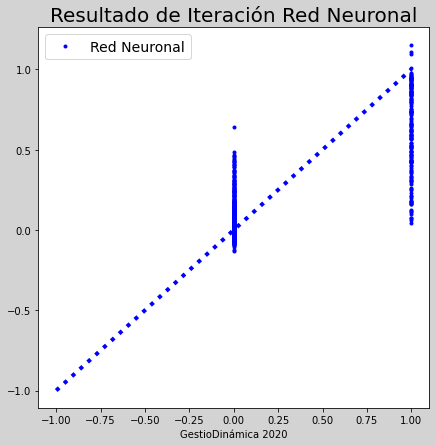

In [46]:
#@title Gráfica
plt.figure(figsize=(7,7), facecolor='lightgray')

plt.plot(y_np, pred, 'bo', ms=3, label='Red Neuronal')
plt.plot([-1,1], [-1, 1], 'b:', lw=4)

plt.title('Resultado de Iteración Red Neuronal', fontsize=20)
plt.legend(loc='best', fontsize=14)
plt.xlabel('GestioDinámica 2020')
plt.show()

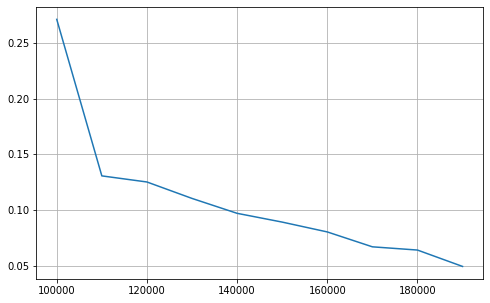

In [47]:
err_df = pd.DataFrame(errores)
plt.figure(figsize=(8,5), facecolor='white')
plt.plot(err_df[0], err_df[1])
plt.grid(True)
plt.show()

In [50]:
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
mlm = lr.fit(X_np, y_np)
nb = GaussianNB()
mnb = nb.fit(X_np, y_np)
lreg = LinearRegression()
mlreg = lreg.fit(X_np, y_np)
pred_lm = mlm.predict(X_np)
pred_nb = mnb.predict(X_np)
pred_lrm = lreg.predict(X_np)
len(X_np), len(pred_lm)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(900, 900)

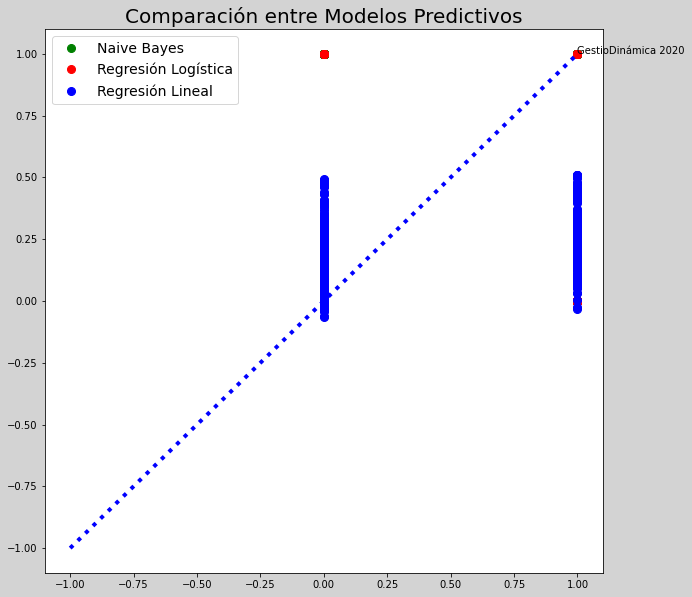

In [51]:
#@title Gráfica
plt.figure(figsize=(10,10), facecolor='lightgray')

#plt.plot(y_np, pred, 'bo', ms=8, label='Red Neuronal')
plt.plot(y_np, pred_nb, 'go', ms=8, label='Naive Bayes')
plt.plot(y_np, pred_lm, 'ro', ms=8, label='Regresión Logística')
plt.plot(y_np, pred_lrm, 'bo', ms=8, label='Regresión Lineal')
plt.plot([-1,1], [-1, 1], 'b:', lw=4)

plt.title('Comparación entre Modelos Predictivos', fontsize=20)
plt.legend(loc='best', fontsize=14)
plt.text(1,1, 'GestioDinámica 2020')
plt.show()

In [52]:
data_test = X[0:10].cuda()

In [53]:
data_cat.columns

Index(['Edad_AdultoMayor', 'Edad_Joven', 'Edad_Niño', 'Sexo_M', 'Area_A2',
       'Area_A3', 'Area_A4'],
      dtype='object')

In [54]:
data_test

tensor([[0.0000, 0.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.7083, 0.2500],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.1250, 0.7500],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.7917, 0.5000],
        [0.0000, 0.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.9583, 0.2500],
        [0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.2917, 1.0000],
        [0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.9167, 0.0000],
        [1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2500],
        [0.0000, 0.0000, 1.0000, 1.0000, 0.0000, 1.0000, 0.0000, 0.6250, 0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0417, 1.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3750, 0.0000]],
       device='cuda:0')

In [55]:
model(data_test)

tensor([[0.0732],
        [0.0390],
        [0.0750],
        [0.0456],
        [0.2794],
        [0.1597],
        [0.5690],
        [0.0218],
        [0.7286],
        [0.0046]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [56]:
#print(pred[0:10])
indices = [i for i in range(len(pred)) if pred[i] < 0.45]
len(indices)

779

In [57]:
data_10 = dataset.iloc[indices,:]
data_10 = data_10.reindex()
data_11 = data_10[['Edad', 'Sexo', 'Area', 'Violento']]
data_12 = data_11[data_11.Violento == 'No Violento']
data_12.head()

,Edad,Sexo,Area,Violento
0,Niño,M,A1,No Violento
1,Niño,F,A3,No Violento
2,Niño,F,A1,No Violento
3,Niño,M,A1,No Violento
5,Adulto,M,A4,No Violento


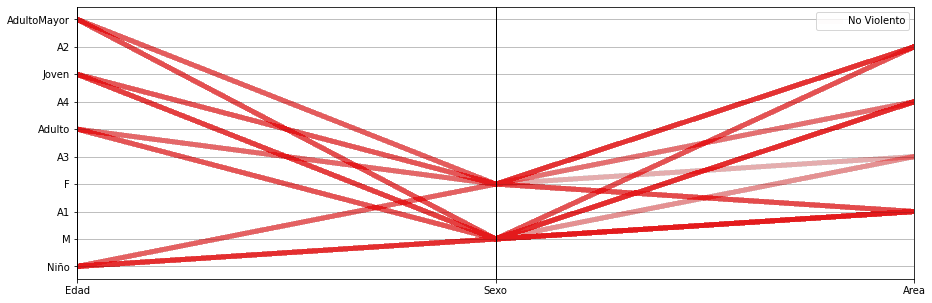

In [58]:
DATA = data_12
clase = 'Violento'
plt.figure(figsize=(15, 5), facecolor='white')
pd.plotting.parallel_coordinates(DATA, class_column=clase, lw=5, alpha=0.01, colormap='Set1')
plt.legend(loc='best')
plt.show()

### Referencias
https://medium.com/@benjamin.phillips22/simple-regression-with-neural-networks-in-pytorch-313f06910379
